In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
# import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *
import cmocean.cm as cmo
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='125GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=5)
from dask.distributed import Client
client = Client(cluster)
client

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42453 instead
  warnings.warn(


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=117G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:44838 --name dummy-name --nthreads 36 --memory-limit 116.42GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/42453/status,
Dashboard: /proxy/42453/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:44838,Workers: 0
Dashboard: /proxy/42453/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [ ]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds = ds.where(ds.thkcello > 1e-9)
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")
ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))
ds_ctrl.coords['year'] = ds_ctrl.time.values

ds = ds.sel(year = slice(1990, 2014))
ds_ctrl = ds_ctrl.sel(year = slice(1990, 2014))

In [63]:
ds_ctrl = get_sigma2(ds_ctrl)
ds = get_sigma2(ds)

In [64]:
def weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

In [65]:
ds_ctrl.year

<xarray.DataArray 'year' (year: 25)> Size: 200B
array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014])
Coordinates:
    time     (year) int64 200B dask.array<chunksize=(1,), meta=np.ndarray>
  * year     (year) int64 200B 1990 1991 1992 1993 1994 ... 2011 2012 2013 2014

In [85]:
glodap_gridded = xr.open_mfdataset(datadir("GLODAP_gridded.nc")).sel(time = slice(1990, 2014))
area=np.cos(np.radians(abs(glodap_gridded.lat)))*(111.1*111.1*1000*1000)
AREA, _ = np.meshgrid(area, glodap_gridded.lon)
glodap_gridded["area"] = (("lon", "lat"), AREA)

glodap_gridded_var = glodap_gridded[["G2cfc11", "area"]]

glodap_gridded_var["mask"] = xr.where(~np.isnan(glodap_gridded_var["G2cfc11"]), 1, np.nan)
glodap_gridded_var["area_mask"] = glodap_gridded_var["mask"] * glodap_gridded_var["area"]
glodap_gridded_var.coords['time'] = ds.year.values
glodap_gridded_var = glodap_gridded_var.rename({'time':'year'})

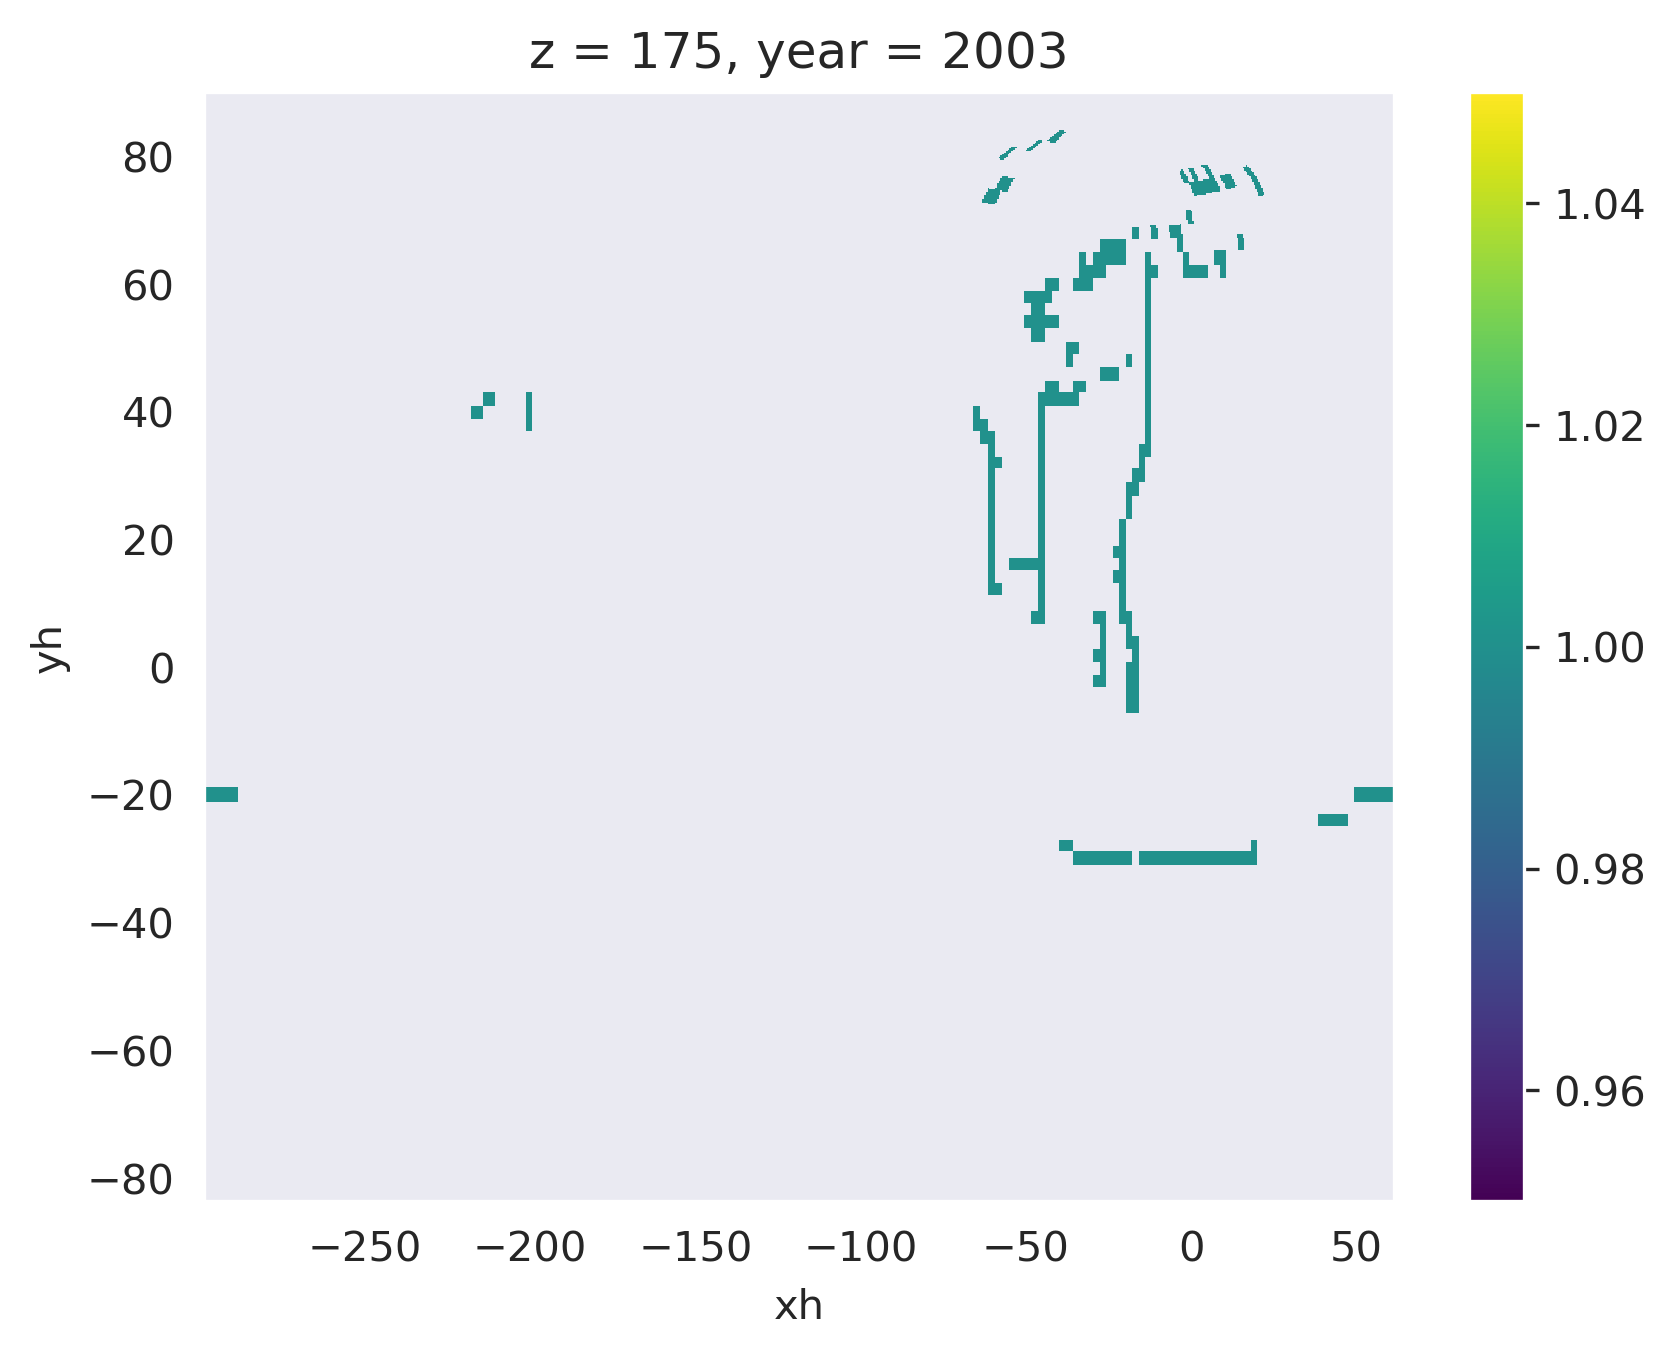

In [93]:
regridder = xe.Regridder(glodap_gridded_var["mask"], ds, "nearest_s2d")
glodap_mask = regridder(glodap_gridded_var["mask"])
# glodap_mask.sel(time = 
glodap_mask.sel(year = 2003, z = 175).plot()

In [32]:
ds_ctrl_masked = ds_ctrl.where(glodap_mask == 1)
ds_ctrl_masked = weighted_average(ds_ctrl_masked.where(ds_ctrl_masked.lat < -40)).compute()

ds_masked = ds.where(glodap_mask == 1)
ds_masked = weighted_average(ds_masked.where(ds_masked.lat < -40)).compute()

/tmp/ipykernel_101644/546022322.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tmp/ipykernel_101644/546022322.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 20.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [33]:
interp_ctrl_timeseries = interpolate_section(ds_ctrl_masked, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_hist_timeseries = interpolate_section(ds_masked, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")

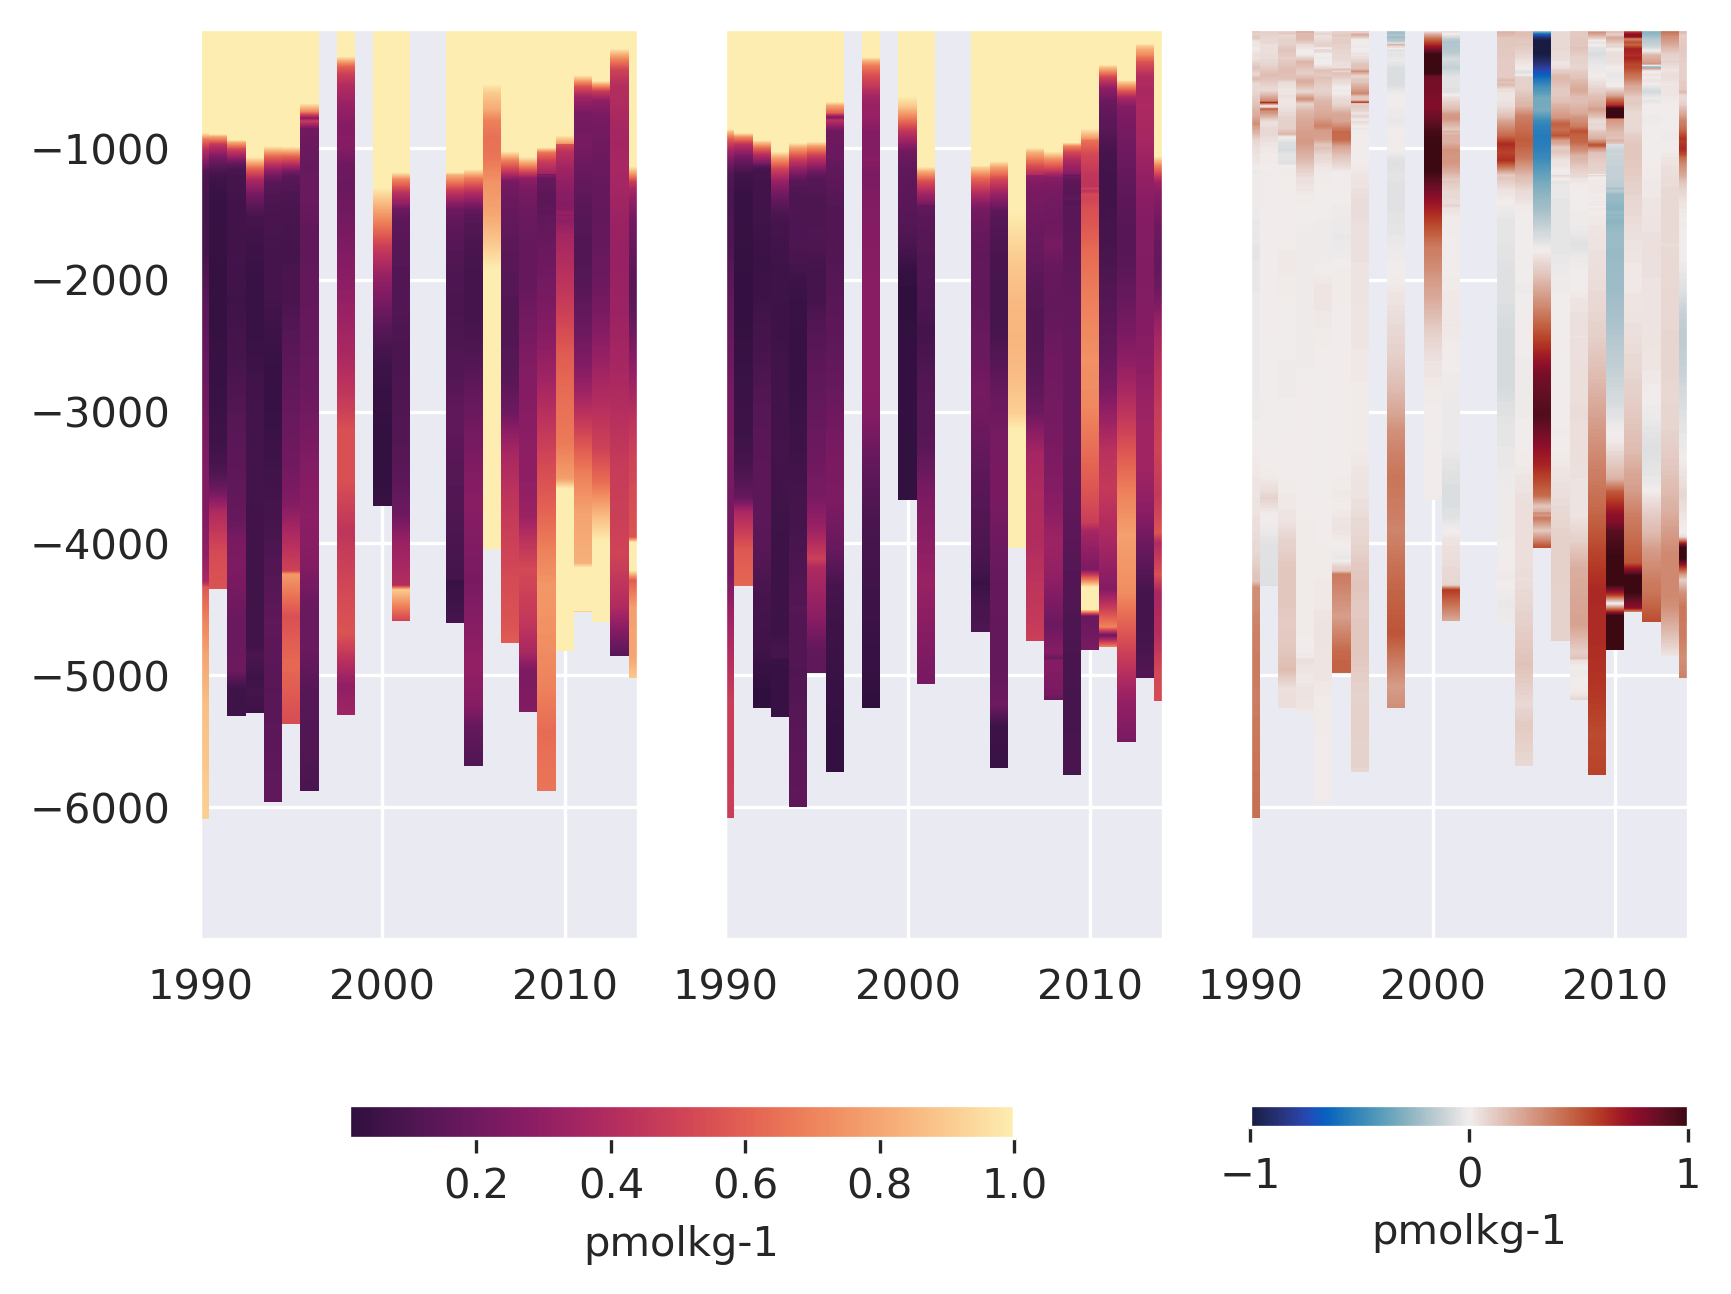

In [34]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, sharey = True)

tracer = "cfc11"
tmp1 = interp_ctrl_timeseries.cfc11 * variable_kwargs[tracer]["conversion"]
tmp1 = tmp1.where(tmp1 > 0)
ax[0].pcolormesh(interp_ctrl_timeseries.year, tmp1.z, tmp1, vmax = 1, vmin = 1e-2, cmap = cmo.matter_r)
# ax[0].contour(interp_ctrl_timeseries.year, tmp1.z, interp_ctrl_timeseries.sigma2, colors = "white")
ax[0].set_xlim(1990, 2014)

tmp2 = interp_hist_timeseries.cfc11  * variable_kwargs[tracer]["conversion"]
tmp2 = tmp2.where(tmp2 > 0)
cm = ax[1].pcolormesh(interp_hist_timeseries.year, tmp2.z, tmp2, vmax = 1, vmin = 1e-2, cmap = cmo.matter_r)
# ax[1].contour(interp_hist_timeseries.year, tmp1.z, interp_hist_timeseries.sigma2, colors = "white")

ax[1].set_xlim(1990, 2014)

tmp3 = tmp1.values - tmp2.values
cm1 = ax[2].pcolormesh(interp_hist_timeseries.year, tmp2.z, tmp3, vmin = -1, vmax = 1, cmap = cmo.balance)
ax[2].set_xlim(1990, 2014)

fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], orientation = "horizontal", fraction = 0.03)
fig.colorbar(cm1, ax = ax[2], label = variable_kwargs[tracer]["units"], orientation = "horizontal", fraction = 0.03)

In [139]:
tmp = glodap_gridded_var.where(glodap_gridded_var["lat"] < -40)

In [140]:
tmp

<xarray.Dataset> Size: 768MB
Dimensions:    (year: 25, lon: 180, lat: 90, z: 79)
Coordinates:
  * lon        (lon) int64 1kB -180 -178 -176 -174 -172 ... 170 172 174 176 178
  * lat        (lat) int64 720B -90 -88 -86 -84 -82 -80 ... 78 80 82 84 86 88
  * z          (z) int64 632B 100 175 250 325 400 ... 5650 5725 5800 5875 5950
  * year       (year) int64 200B 1990 1991 1992 1993 ... 2011 2012 2013 2014
Data variables:
    G2cfc11    (year, lon, lat, z) float64 256MB dask.array<chunksize=(25, 180, 90, 79), meta=np.ndarray>
    area       (lon, lat) float64 130kB 7.558e-07 4.308e+08 8.61e+08 ... nan nan
    mask       (year, lon, lat, z) float64 256MB dask.array<chunksize=(25, 180, 90, 79), meta=np.ndarray>
    area_mask  (year, lon, lat, z) float64 256MB dask.array<chunksize=(25, 180, 90, 79), meta=np.ndarray>

In [141]:
tmp1 = (tmp["G2cfc11"] * tmp["area_mask"]).sum(["lat", "lon"])
tmp = tmp1 / tmp["area_mask"].sum(["lat", "lon"])

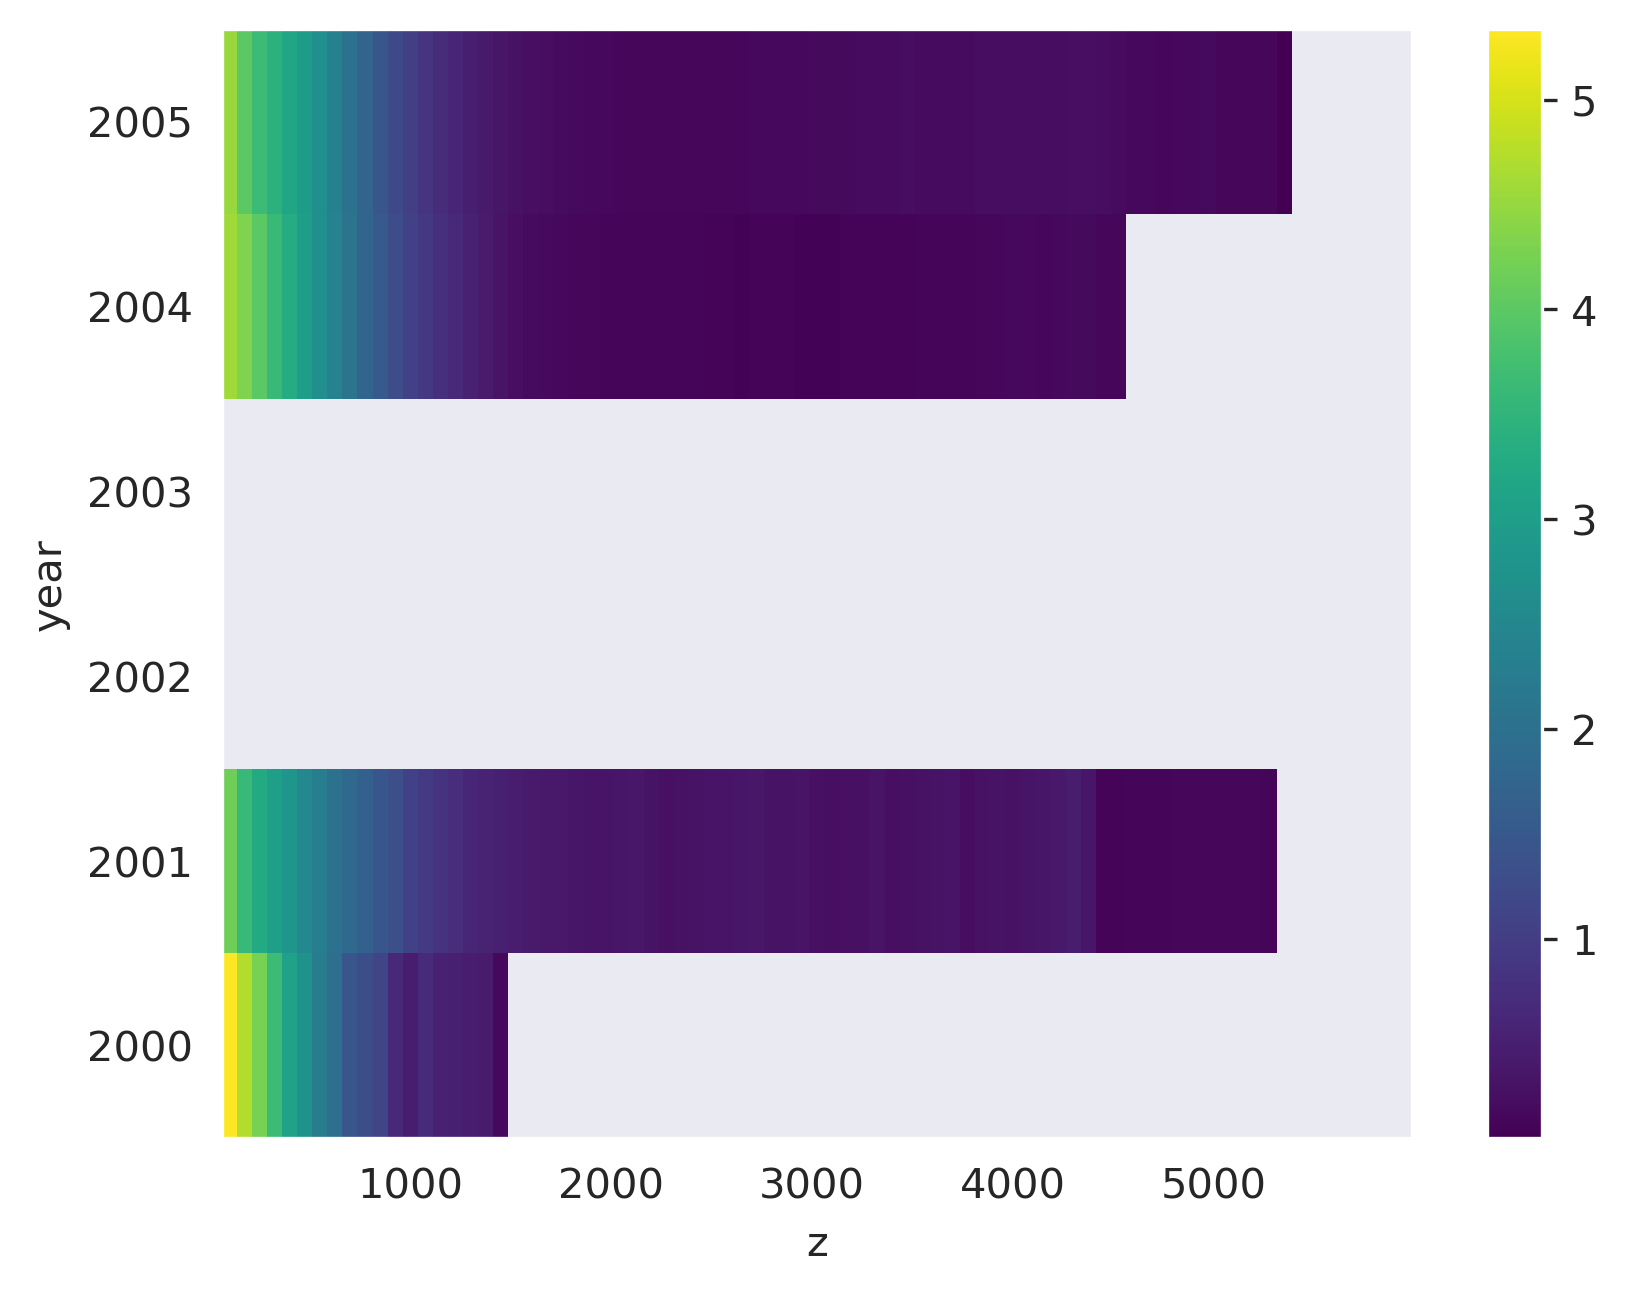

In [142]:
tmp.sel(year = slice(2000, 2005)).plot()

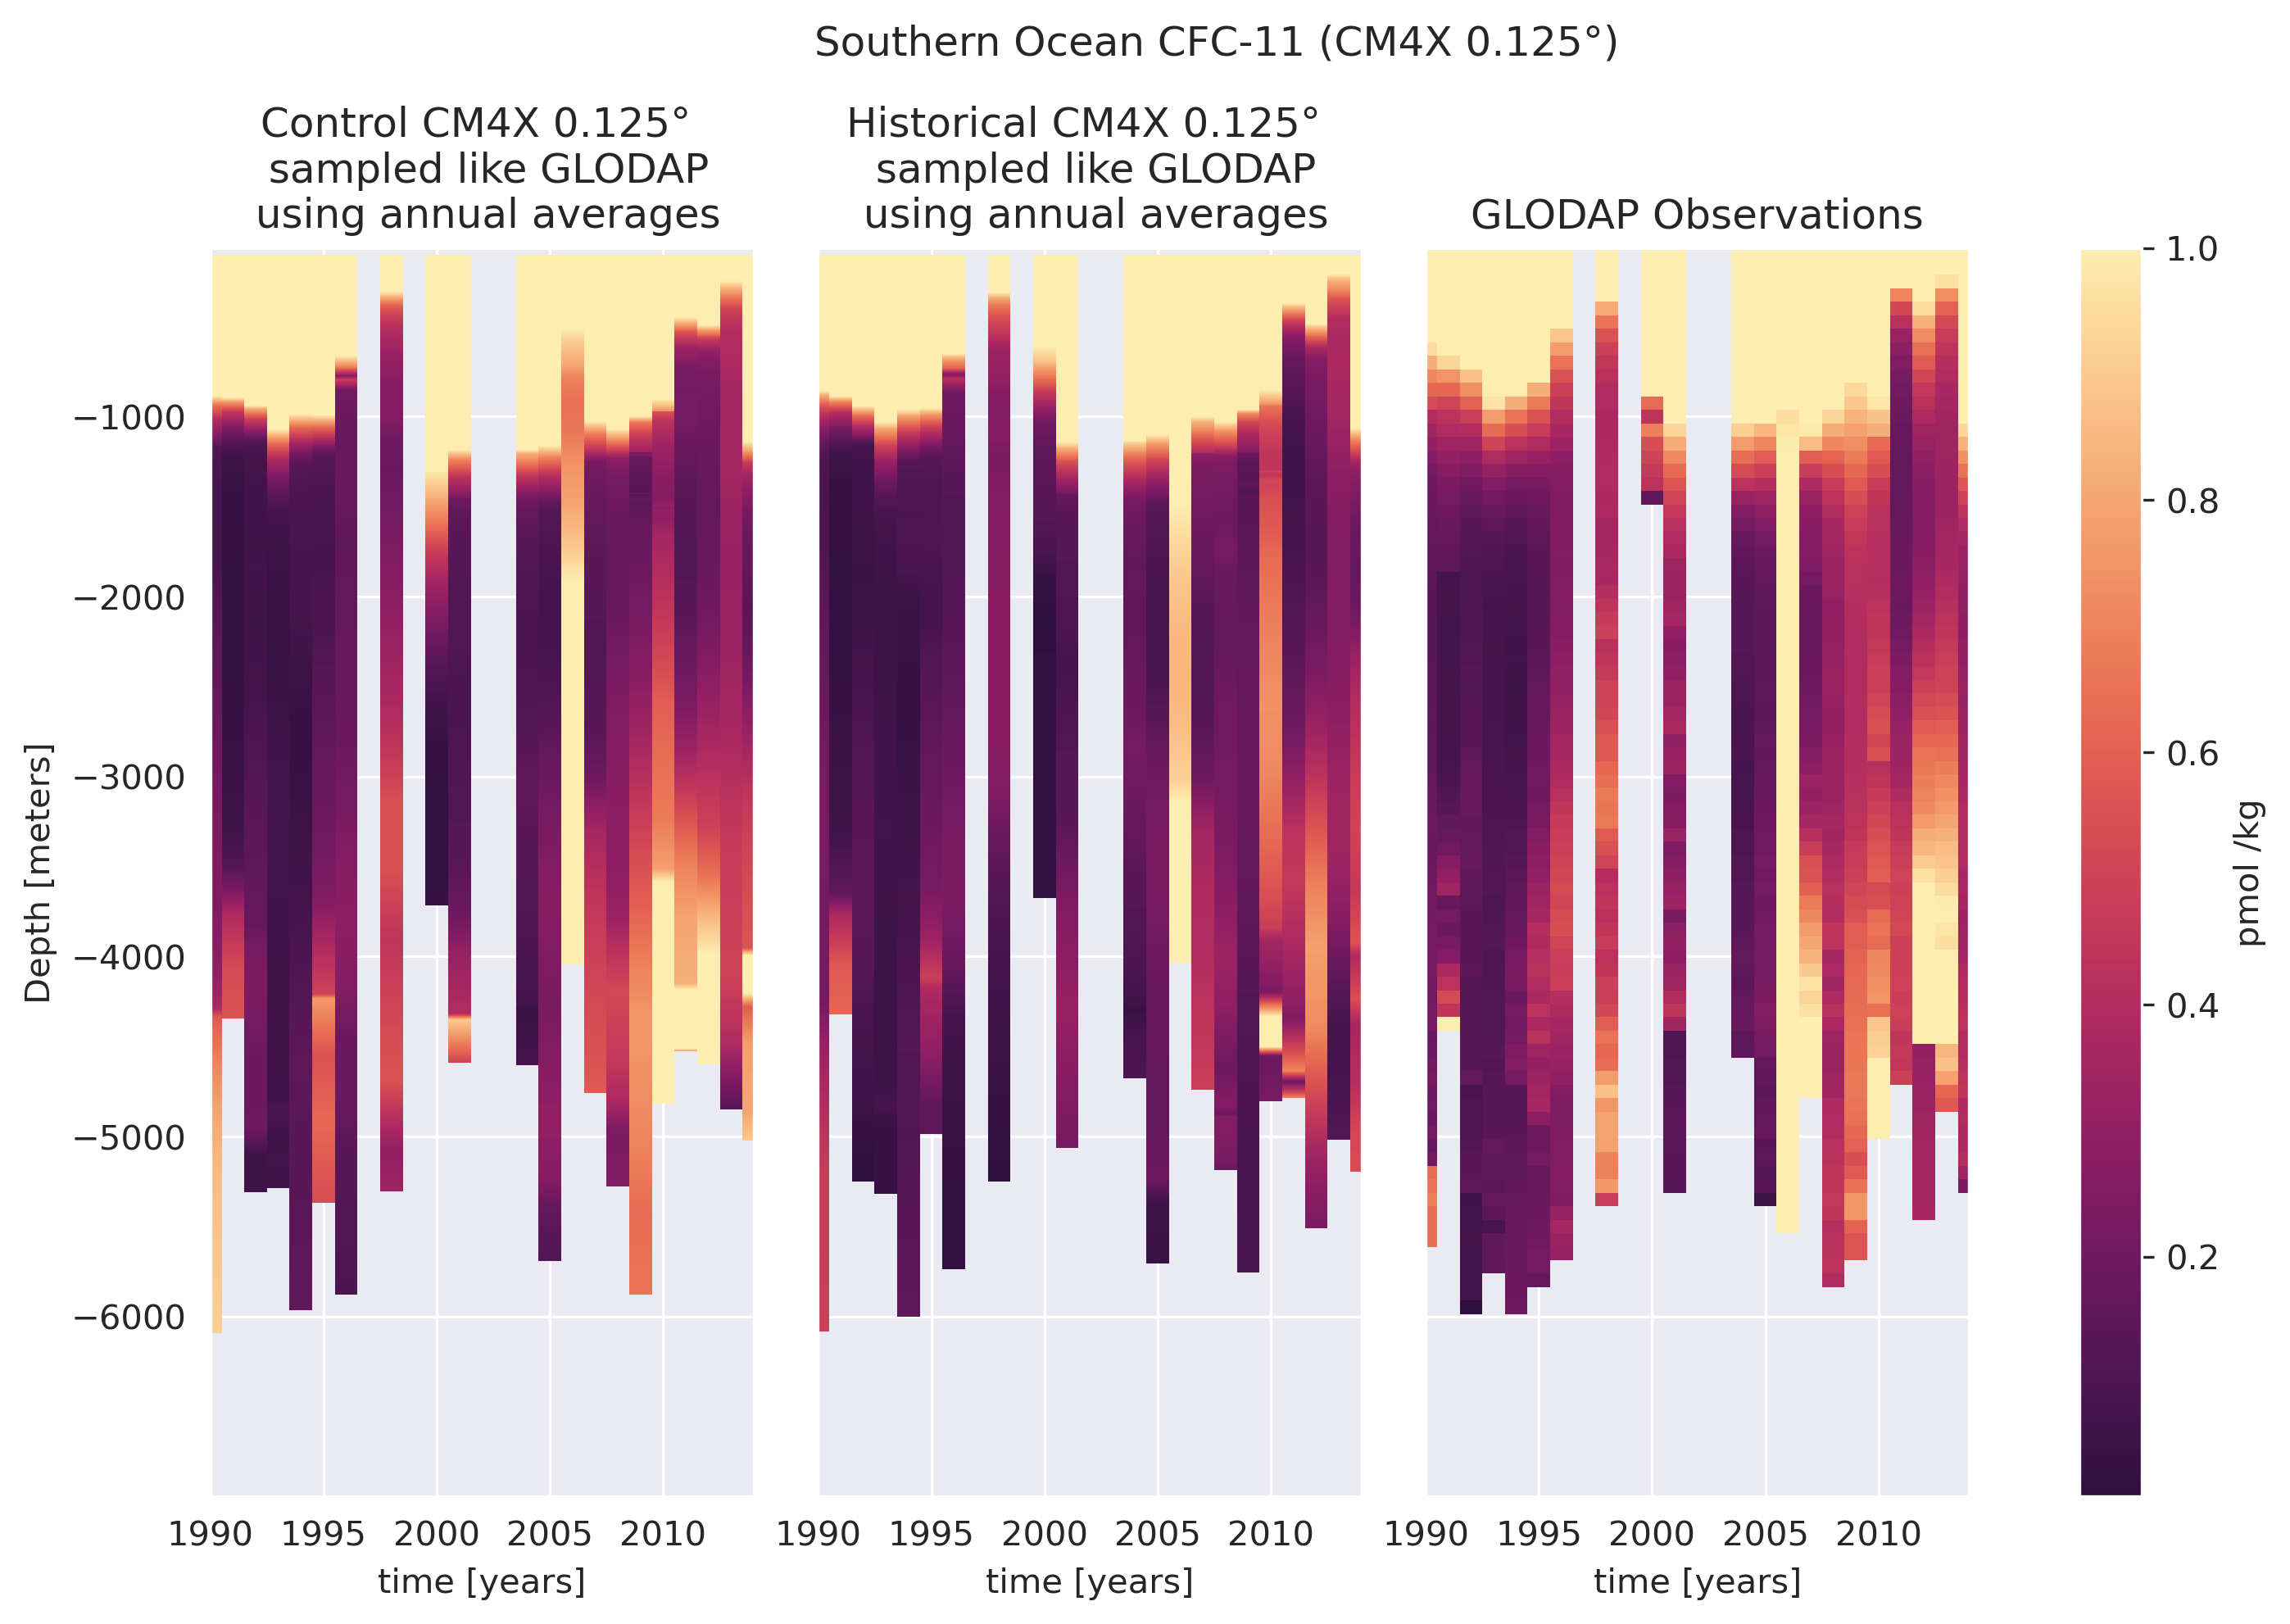

In [156]:
fig, ax = plt.subplots(1, 3, figsize = (10, 6.5), sharey = True)

tracername = "CFC-11"
tmp1 = interp_ctrl_timeseries.cfc11 * variable_kwargs["cfc11"]["conversion"]
tmp1 = tmp1.where(tmp1 > 0)
ax[0].pcolormesh(interp_ctrl_timeseries.year, tmp1.z, tmp1, vmax = 1, vmin = 1e-2, cmap = cmo.matter_r)
ax[0].set_xlim(1990, 2014)
ax[0].set_title("Control CM4X 0.125° \n sampled like GLODAP\n using annual averages")
ax[0].set_ylabel("Depth [meters]")

tmp2 = interp_hist_timeseries.cfc11  * variable_kwargs["cfc11"]["conversion"]
tmp2 = tmp2.where(tmp2 > 0)
cm = ax[1].pcolormesh(interp_hist_timeseries.year, tmp2.z, tmp2, vmax = 1, vmin = 1e-2, cmap = cmo.matter_r)

ax[1].set_xlim(1990, 2014)
ax[1].set_title("Historical CM4X 0.125° \n sampled like GLODAP\n using annual averages")

tmp3 = tmp.T
cm1 = ax[2].pcolormesh(tmp.year, -tmp.z, tmp3,  vmax = 1, vmin = 1e-2, cmap = cmo.matter_r)
ax[2].set_xlim(1990, 2014)
ax[2].set_title("GLODAP Observations")

fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")
fig.tight_layout()
fig.colorbar(cm, ax = ax[0:3], label = "pmol /kg")

for a in ax[0:3]:
    a.set_xlabel("time [years]")
